In [7]:
import skimage as ski
from skimage import color,io,filters,measure
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [8]:
%matplotlib inline

In [9]:
numberOfImgs = 4
def show(imgs,CMAP = None):
    cols = 2
    rows = 2
    fig, ax = plt.subplots(rows,cols ,figsize = (10,10),constrained_layout=True)
    fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02,
            hspace=0., wspace=0.)
    [axi.set_axis_off() for axi in ax.ravel()]
    for i in range(rows):
        for j in range(cols):
            ax[i][j].imshow(imgs[i*cols+j],CMAP)

In [70]:
img = [io.imread(str(1+i)+".jpg") for i in range(numberOfImgs)]
#img = [color.rgba2rgb(i) for i in imgRGBA]
#img = ski.img_as_ubyte(img)


In [64]:

#imgG = [color.rgb2gray(i) for i in img]
#imgG = [i[:,:,1] for i in img]
#imgG = color.rgb2hsv(img)[:,:,2]
#show(imgG,"gray")
#print(imgG)

In [65]:
def IncreaseContrast(image):
    #image = image**0.7
    #image = image**3
    #image = np.clip(image -0.1 , 0,1)
    brightness =np.mean(image) 
    print(brightness)
    image = image**(brightness*9)
    print("po " , np.mean(image))
    #image = image**0.5
    #image = ski.filters.sobel(image)
    return image
#imgC = [IncreaseContrast(i) for i in imgG]
#imgLinia = [cv2.line(i , (0,0),(250,250),1 , 10) for i in imgC]
#show(imgLinia , "gray")
#show(imgC,"gray")

In [66]:
def MakeThresholded(img):
    threshold = filters.threshold_otsu(img)
    imgN = img > threshold
    imgN = ski.morphology.remove_small_objects(imgN , imgN.size//1000)
    neigh = np.ones((5,5))
    #imgN = ski.morphology.binary_erosion(imgN,neigh)
    #imgN = ski.morphology.binary_erosion(imgN,neigh)
    #imgN = ski.morphology.binary_erosion(imgN)

    imgN = ski.morphology.binary_dilation(imgN)
    #imgT = ski.morphology.binary_dilation(imgT)

    return imgN
#imgT = [MakeThresholded(i) for i in imgC]

#show(imgT,"gray")


In [71]:
def ExtractObjectsWB(img):
    #img = color.rgb2gray(img)
    img = color.rgb2hsv(img)[:,:,2]
    img = IncreaseContrast(img)
    return MakeThresholded(img)

imgObjects = [ExtractObjectsWB(i) for i in img]

0.2728150969931542
po  0.044399480610669693
0.4886850612375792
po  0.0529671914032743
0.44130907232577543
po  0.09578970048928878
0.38017438580313656
po  0.0740311209235438


In [72]:
def MakeRegions(imgPom):
    labelImg , n = measure.label(imgPom,return_num = True,connectivity = 2)
    print(n)
    return(labelImg , n)

imgLn = [MakeRegions(i) for i in imgObjects]

def ShowRegions(i):
    labels = ski.img_as_ubyte(color.label2rgb(imgLn[i][0], bg_label=0))
    regions = measure.regionprops(imgLn[i][0])
    imgTemp = img[i]
    imgTemp[imgLn[i][0] > 0] = labels[imgLn[i][0] > 0]
    return imgTemp 
    
#temp  = [ShowRegions(i) for i in range(numberOfImgs)]

#show(temp)


2
2
2
5


obraz [0 1 2] 0
2
1
obraz [0 1 2] 1
2
obraz [0 1 2] 2
1
2
obraz [0 1 2 3 4 5] 3
3
2
1
3
6


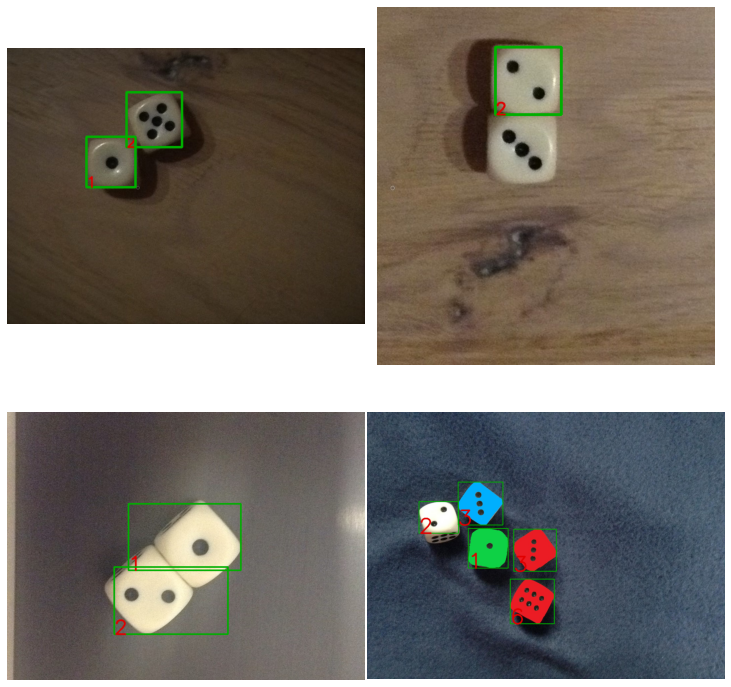

In [73]:
font = cv2.FONT_HERSHEY_SIMPLEX
def printNumberOfDots(n, region , img):
    if(n>1):
        print(n-1)
        y=int(region.centroid[0])
        x=int(region.centroid[1])
        #print("czcionka? ",max(img.shape)//500)
        xr1 = region.bbox[1]
        xr2 = region.bbox[3]
        yr1 = region.bbox[0]
        yr2 = region.bbox[2]
        
        cv2.rectangle(img ,(xr1 , yr1) , (xr2 , yr2), (0, 175, 0) , 3)
        cv2.putText(img, str(n-1), (xr1,yr2), font, max(img.shape)//500, (225,0, 0), max(img.shape)//250, cv2.LINE_AA)
        
def separateDice(imgPom , region , imgToRead  , medianOfRegionsArea , medianOfRegionsWitdh,medianOfRegionsHeight ):
    
    minRow = region.bbox[0]
    maxRow = region.bbox[2]-1
    minCol=region.bbox[1]
    maxCol=region.bbox[3]-1
            #print("sklejone\t row col")
            #print("punkt z min row ",regions[i-1].bbox[0] , np.argmax(imgPom[regions[i-1].bbox[0]]))
            #print("punkt z min col ", np.argmax(imgPom[:,regions[i-1].bbox[1]]),regions[i-1].bbox[1])
            #print("punkt z max row ",regions[i-1].bbox[2]-1 , np.argmax(imgPom[regions[i-1].bbox[2]-1]))
            #print("punkt z max col ", np.argmax(imgPom[:,regions[i-1].bbox[3]-1]),regions[i-1].bbox[3]-1 )
            #wyliczanie prostej przecinającej na pół dwie stykające się kostki leżące poziomo
    if((maxCol-minCol) > (maxRow - minRow)):
        x1=minCol
        x2=maxCol

        y1=np.argmax(imgPom[:,minCol])
        y2=np.argmax(imgPom[:,maxCol])




        if(abs(y1-minRow) > abs(y1-maxRow)):#punkt z min col jest bliżej punkty (minCol , maxRow)
            y1 = (maxRow+2*y1)/3
        else:
            y1 = (minRow + 2*y1)/3
            
        if(abs(y2-minRow) > abs(y2-maxRow)):#punkt z min col jest bliżej punkty (minCol , maxRow)
            y2 = (maxRow+2*y2)/3
        else:
            y2 = (minRow + 2*y2)/3

        #y1 = (minRow + maxRow + y1)/3
        #y2 = (minRow + maxRow + y2)/3
        
        predDiceCount = round((maxCol - minCol)/medianOfRegionsWitdh)
        #print("przewidywano kostek",predDiceCount)
        a = (x1 - x2)/(y1-y2)*(-1)
        imgPom =ski.img_as_ubyte(imgPom)
        for i in range (1, predDiceCount):
            xSrodkowy = ((predDiceCount-i)*x1 + i*x2)/predDiceCount
            #xSrodkowy = (1*x1 + 2*x2)/3
            ySrodkowy = (y1+y2)/2
            #print("nakreślono linie")
            
            b = ySrodkowy - a*xSrodkowy



            colOfminRow = abs(int((minRow - b)/a))
            colOfmaxRow = abs(int((maxRow - b)/a))


            #cv2.circle(imgToRead , (int(xSrodkowy),int(ySrodkowy)), 20,(0,0,0) , 5)
            #cv2.line(imgToRead , (colOfminRow,minRow),(colOfmaxRow,maxRow),(255,255,0) , 5)
            
            cv2.line(imgPom , (colOfminRow,minRow),(colOfmaxRow,maxRow),0 , 5)
        #print("koniec kreślenia linii")
                
    else:
        y1 = minRow
        y2 = maxRow
        x1 = np.argmax(imgPom[minRow,:])
        x2 = np.argmax(imgPom[maxRow,:])
                
        if(abs(x1-minCol) > abs(x1-maxCol)):#punkt z min col jest bliżej punkty (minCol , maxRow)
            x1 = (minCol+2*x1)/3
        else:
            x1 = (maxCol+2*x1)/3
        
        if(abs(x2-minCol) > abs(x2-maxCol)):#punkt z min col jest bliżej punkty (minCol , maxRow)
            x2 = (minCol+2*x2)/3

        else:
            x2 = (maxCol+2*x2)/3
                
        #x1 = (minCol + maxCol + x1)/3
        #x2 = (minCol + maxCol + x2)/3
        predDiceCount = round((maxRow - minRow)/medianOfRegionsHeight)        
        xSrodkowy = (x1+x2)/2
        a = (x1 - x2)/(y1-y2)*(-1)
        imgPom =ski.img_as_ubyte(imgPom)
        for i in range(1,predDiceCount):
            ySrodkowy = ((predDiceCount-i)*y1+i*y2)/predDiceCount


            b = ySrodkowy - a*xSrodkowy

            rowOfminCol = abs(int(a*minCol + b))
            rowOfmaxCol = abs(int(a*maxCol + b))

            #cv2.circle(imgToRead , (int(xSrodkowy),int(ySrodkowy)), 20,(0,255,0) , 5)
            #cv2.line(imgToRead , (minCol,rowOfminCol),(maxCol,rowOfmaxCol),(255,255,0) , 5)
            
            cv2.line(imgPom , (minCol,rowOfminCol),(maxCol,rowOfmaxCol),0 , 5)                
                
    imgPom = ski.morphology.binary_dilation(imgPom)
    
    newImgPom, n = measure.label(imgPom,background=False,return_num = True,connectivity = 2)
    #print("ilość kostek" , n)
    sepDiceRegions = ski.measure.regionprops(newImgPom)
         
    for label in range(1,n+1):
        if(sepDiceRegions[label-1].area > medianOfRegionsArea*0.1):
            sepDiceImg = (newImgPom == label)
            #print("area rozdzielonych ", sepDiceRegions[label-1].area)
            if(sepDiceRegions[label-1].area < medianOfRegionsArea*1.5):

                neigh = np.ones((sepDiceRegions[label-1].area//2580,sepDiceRegions[label-1].area//2580))
                #print("dylatacja" , sepDiceRegions[label-1].bbox)
                #print("wymiary obrazu ", sepDiceImg.shape)

                sepDiceImg = ski.morphology.binary_dilation(sepDiceImg,neigh)

                x, numberOfDots = measure.label(sepDiceImg,background=True,return_num = True,connectivity = 2)
                printNumberOfDots(numberOfDots,sepDiceRegions[label-1],imgToRead,)
            else:
                imgToRead = separateDice(sepDiceImg,sepDiceRegions[label-1],imgToRead,medianOfRegionsArea,medianOfRegionsWitdh,medianOfRegionsHeight)
    #print("powrót z wywołania")
    return imgToRead
    
def ReadDie(labelImg , N , j):
    print("obraz",np.unique(labelImg),j)
    regions = measure.regionprops(labelImg)
    areasOfRegions = [r.area for r in regions]
    witdhOfRegions = [ r.bbox[3]-r.bbox[1] for r in regions]
    heightOfRegions = [ r.bbox[2]-r.bbox[0] for r in regions]
    medianOfRegionsArea = np.median(areasOfRegions)
    medianOfRegionsWitdh = np.median(witdhOfRegions)
    medianOfRegionsHeight = np.median(heightOfRegions)
    #print("maediana" ,medianOfRegionsArea )
    imgToRead = img[j]
    
    for i in range(1,N+1):
        if(regions[i-1].area > medianOfRegionsArea*0.1):
            imgPom = (labelImg == i)
            if(regions[i-1].area < 1.5 *  medianOfRegionsArea):

                neigh = np.ones((regions[i-1].area//2580,regions[i-1].area//2580))
                imgPom = ski.morphology.binary_dilation(imgPom,neigh)
                #imgPom = ski.morphology.binary_dilation(imgPom)
                #io.imshow(imgPom,cmap="gray")
                #print("area " , regions[i-1].area)

                #imgPom = 1-imgPom
                x, n = measure.label(imgPom,background=True,return_num = True,connectivity = 2)
                #print("n " , n)
                #xr = measure.regionprops(x)
                printNumberOfDots(n,regions[i-1],imgToRead)
            else:
                imgToRead = separateDice(imgPom,regions[i-1],imgToRead,medianOfRegionsArea,medianOfRegionsWitdh,medianOfRegionsHeight )
           
        
    return imgToRead
        
imgRead = [ReadDie(imgLn[i][0] , imgLn[i][1] , i) for i in range(numberOfImgs)]        
show(imgRead)        

    

In [48]:
test = np.array([[1,2,3],
       [6,4,5]])
test2 = test[:,1]
print(test.shape)

(2, 3)


In [135]:
x = round(5.5)
print(x)

6


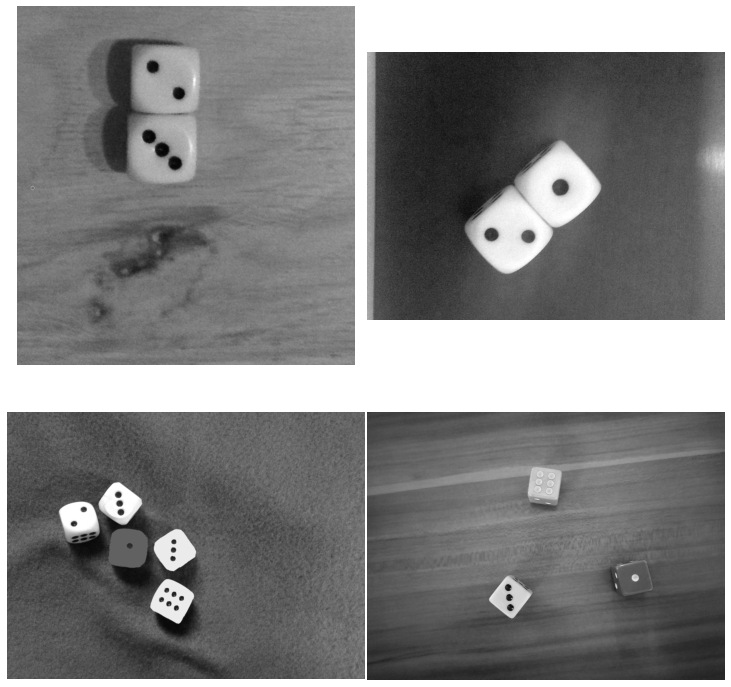

In [44]:
def foo(img):
    img = color.rgb2hsv(img)[:,:,2]
    #img = img[:,:,0]
    #img = ski.img_as_float(img)
    #img = IncreaseContrast(img)
    #img = MakeThresholded(img)
    return img
imgTest = [foo(i) for i in img]
show(imgTest , CMAP = "gray")